In [54]:
import os
import json
import uuid
import pytz

from datetime import datetime
from collections import namedtuple

import lusid
import lusid.models as models

from lusidjam import RefreshingToken

LUSID_INSTRUMENT_IDENTIFIER = 'Instrument/default/LusidInstrumentId'

secrets_path = '/Users/msingh/Projects/lusidws/secrets.json'

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

In [55]:
instruments = [
    {"Figi": "BBG000C6K6G9", "Name": "VODAFONE GROUP PLC"},
    {"Figi": "BBG000C04D57", "Name": "BARCLAYS PLC"},
    {"Figi": "BBG000FV67Q4", "Name": "NATIONAL GRID PLC"},
    {"Figi": "BBG000BF0KW3", "Name": "SAINSBURY (J) PLC"},
    {"Figi": "BBG000BF4KL1", "Name": "TAYLOR WIMPEY PLC"},
]

figis_to_create = { i['Figi']: models.InstrumentDefinition(name=i['Name'], identifiers={ 'Figi': models.InstrumentIdValue(value=i['Figi']) }) for i in instruments }

instruments_api = api_factory.build(lusid.api.InstrumentsApi)
upsert_response = instruments_api.upsert_instruments(
    request_body=figis_to_create
)

if len(upsert_response.failed) != 0:
    raise Exception(upsert_response.failed)
    
ids = instruments_api.get_instruments(
    identifier_type='Figi', request_body=[i['Figi'] for i in instruments]
)

instrument_ids = [i.lusid_instrument_id for i in ids.values.values()]

In [56]:
instrument_ids

['LUID_00003D69',
 'LUID_00003D5X',
 'LUID_00003D6A',
 'LUID_00003D6B',
 'LUID_00003D6C']

In [58]:
def build_transaction(trade_spec):
    return models.TransactionRequest(
        transaction_id=str(uuid.uuid4()),
        type='StockIn',
        instrument_identifiers={LUSID_INSTRUMENT_IDENTIFIER: trade_spec.id},
        transaction_date=trade_spec.trade_date,
        settlement_date=trade_spec.trade_date,
        units=100,
        transaction_price=models.TransactionPrice(price=trade_spec.price),
        total_consideration=models.CurrencyAndAmount(
            amount=100*trade_spec.price, currency='GBP'
        ),
        source='Client'
    )

In [59]:
transactions_portfolio_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
aggregation_api = api_factory.build(lusid.api.AggregationApi)

In [60]:
scope = 'finbourne'
portfolio_code = 'valuationPortfolio'
effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)

request = models.CreateTransactionPortfolioRequest(
    display_name=portfolio_code,
    code=portfolio_code,
    base_currency='GBP',
    created=effective_date,
)

try:

    result = transactions_portfolio_api.create_portfolio(scope=scope, create_transaction_portfolio_request=request)

except lusid.ApiException as e:
    print(json.loads(e.body)['title'])

Could not create a portfolio with id 'valuationPortfolio' because it already exists in scope 'finbourne'.


In [61]:
TransactionSpec = namedtuple("TransactionSpec", "id price trade_date")
transaction_specs = [
    TransactionSpec(instrument_ids[0], 101, effective_date),
    TransactionSpec(instrument_ids[1], 102, effective_date),
    TransactionSpec(instrument_ids[2], 103, effective_date),
]
transaction_specs.sort(key=lambda ts: ts.id)

new_transactions = list(map(build_transaction, transaction_specs))
add_transactions_result = transactions_portfolio_api.upsert_transactions(
    scope=scope, code=portfolio_code, transaction_request=new_transactions
)

In [62]:
instrument_quotes = {
    instrument_ids[i]: models.UpsertQuoteRequest(
        quote_id=models.QuoteId(
            quote_series_id=models.QuoteSeriesId(
                provider="DataScope",
                instrument_id=instrument_ids[i],
                instrument_id_type="LusidInstrumentId",
                quote_type="Price",
                field="Mid",
            ),
            effective_at=effective_date,
        ),
        metric_value=models.MetricValue(value=i * 100, unit="GBP"),
        lineage="InternalSystem",
    )
    for i in range(1, 4)
}

response = quotes_api.upsert_quotes(scope=scope, request_body=instrument_quotes)

In [63]:
recipe_scope = 'valuations'
recipe_code = 'market_value'

configuration_recipe = models.ConfigurationRecipe(
    scope=recipe_scope,
    code=recipe_code,
    market=models.MarketContext(
        market_rules=[
            models.MarketDataKeyRule(
                key="Equity.LusidInstrumentId.*",
                supplier="DataScope",
                data_scope=scope,
                quote_type="Price",
                field="Mid",
            )
        ],
        suppliers=models.MarketContextSuppliers(
            commodity='DataScope',
            credit='DataScope',
            equity='DataScope',
            fx='DataScope',
            rates='DataScope',
        ),
        options=models.MarketOptions(
            default_supplier='DataScope',
            default_instrument_code_type='LusidInstrumentId',
            default_scope=scope,
        )
    )
)

upsert_configuration_recipe_response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=models.UpsertRecipeRequest(
        configuration_recipe=configuration_recipe
    )
)

In [64]:
valuation_request = models.ValuationRequest(
    recipe_id=models.ResourceId(scope=recipe_scope, code=recipe_code),
    metrics=[
        models.AggregateSpec('Instrument/default/Name', 'Value'),
        models.AggregateSpec('Holding/default/PV', 'Proportion'),
        models.AggregateSpec('Holding/default/PV', 'Sum'),
    ],
    group_by=['Instrument/default/Name'],
    portfolio_entity_ids=[
        models.PortfolioEntityId(scope=scope, code='valuationPortfolio')
    ],
    valuation_schedule=models.ValuationSchedule(
        effective_at=effective_date.isoformat()
    ),
)

valuation = aggregation_api.get_valuation(valuation_request=valuation_request)

In [65]:
for item in valuation.data:
    print('\t{}\t{}\t{}'.format(
        item['Instrument/default/Name'], 
        item['Proportion(Holding/default/PV)'],
        item['Sum(Holding/default/PV)'],
    ))

	VODAFONE GROUP PLC	0.1111111111111111	40000.0
	SAINSBURY (J) PLC	0.3333333333333333	120000.0
	NATIONAL GRID PLC	0.3333333333333333	120000.0
	BARCLAYS PLC	0.0	0.0
	TAYLOR WIMPEY PLC	0.2222222222222222	80000.0


In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = []
values = []

for item in valuation.data:
    labels.append(item['Instrument/default/Name'])
    values.append(item['Proportion(Holding/default/PV)'] * 100)

TypeError: can't multiply sequence by non-int of type 'float'

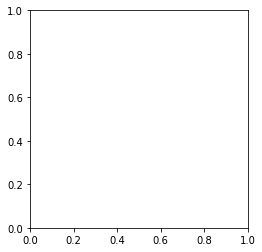

In [67]:
fig1, ax1 = plt.subplots()
ax1.pie(values, labels, autopct="%1.1f%%", shadow=True, startangle=90)
ax1.axis('equal')

plt.show()